## Feature engineering & EDA notebook
Created by Nikolay Pavlychev \
email: nikolaypavlychev@ya.ru

In [2]:
# Standard python libraries
import os

# Installed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %pip install lightautoml==0.3.8b1

In [3]:
sales = pd.read_csv('./data/sales_history_dataset.csv', sep=';')
sales.dtypes

date                 object
date_block_num        int64
shop_id               int64
item_id               int64
item_price          float64
item_cnt_day        float64
item_category_id      int64
dtype: object

In [4]:
sales['date'] =pd.to_datetime(sales['date'],format="%d.%m.%Y")


In [5]:
sales['ID'] = sales['shop_id'].astype(str) + '_' + sales['item_id'].astype(str)

## Target and features preparation

In [6]:
sales_agg_features = sales.groupby(by=['ID', 'item_category_id', 'date_block_num']).agg({'item_price':['sum','mean'],
                                                                    'item_cnt_day':['sum','mean']})

sales_agg_features.head(10)

item_price        item_cnt_day     
                                               sum   mean          sum mean
ID      item_category_id date_block_num                                    
0_1000  67               0                   290.0   58.0          5.0  1.0
                         1                   232.0   58.0          4.0  1.0
0_10004 40               1                    64.0   64.0          1.0  1.0
0_1001  67               0                   116.0   58.0          2.0  1.0
0_10012 40               0                    76.0   76.0          1.0  1.0
                         1                   152.0   76.0          2.0  1.0
0_1002  67               0                   116.0   58.0          2.0  1.0
0_1003  67               0                   116.0   58.0          2.0  1.0
0_10033 55               1                   110.0  110.0          1.0  1.0
0_10038 40               1                    69.0   69.0          1.0  1.0

In [7]:
sales_agg_features = sales_agg_features.reset_index()

sales_agg_features.head(5)

ID item_category_id date_block_num item_price       item_cnt_day     
                                                  sum  mean          sum mean
0   0_1000               67              0      290.0  58.0          5.0  1.0
1   0_1000               67              1      232.0  58.0          4.0  1.0
2  0_10004               40              1       64.0  64.0          1.0  1.0
3   0_1001               67              0      116.0  58.0          2.0  1.0
4  0_10012               40              0       76.0  76.0          1.0  1.0

In [8]:
sales_agg_features_rename = ['_'.join(col) for col in sales_agg_features.columns.values[3:]]
sales_agg_features_rename

['item_price_sum', 'item_price_mean', 'item_cnt_day_sum', 'item_cnt_day_mean']

In [9]:
sales_agg_features.columns = ['ID', 'item_category_id', 'date_block_num', 'item_price_sum', 'item_price_mean', 'item_cnt_day_sum', 'item_cnt_day_mean']
sales_agg_features.head(5)

,ID,item_category_id,date_block_num,item_price_sum,item_price_mean,item_cnt_day_sum,item_cnt_day_mean
0,0_1000,67,0,290.0,58.0,5.0,1.0
1,0_1000,67,1,232.0,58.0,4.0,1.0
2,0_10004,40,1,64.0,64.0,1.0,1.0
3,0_1001,67,0,116.0,58.0,2.0,1.0
4,0_10012,40,0,76.0,76.0,1.0,1.0


In [ ]:
def create_dataset(data):
    '''
    The function, taking as input a time series for each monthly slice of the number of sales, determines the slice t+1, which is the target variable

            Parameters:
                    data (pd.DataFrame): aggregate subset for unique item-shop pair
        
            Returns:
                    data (pd.DataFrame): transformed subset with target value of sales 
    '''
    data = data.reset_index(drop=True)
    data = data.sort_values(by='date_block_num',ascending=True)
    data['target'] = np.nan

    if len(data['date_block_num'].values)>=2:
        for i, month in enumerate(data['date_block_num'].values):
            if (month+1) in data['date_block_num'].values:
                data.loc[i,'target'] = data.loc[i+1,'item_cnt_day_sum']
    
    return data


In [23]:
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)

sales_agg_features_target = applyParallel(sales_agg_features.groupby(by=['ID', 'item_category_id']), create_dataset)

In [24]:
sales_agg_features_target.shape

(1609124, 8)

In [31]:
sales_agg_features_target_train_test = sales_agg_features_target[~sales_agg_features_target['target'].isnull()]
sales_agg_features_target_train_test.shape

(676738, 8)

In [26]:
sales_agg_features_target.to_csv('./data/sales_agg_features_target.csv',sep=';',index=False)

## Target and features EDA

In [10]:
sales_agg_features_target = pd.read_csv('./data/sales_agg_features_target.csv',sep=';')
sales_agg_features_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ID                 1609124 non-null  object 
 1   item_category_id   1609124 non-null  int64  
 2   date_block_num     1609124 non-null  int64  
 3   item_price_sum     1609124 non-null  float64
 4   item_price_mean    1609124 non-null  float64
 5   item_cnt_day_sum   1609124 non-null  float64
 6   item_cnt_day_mean  1609124 non-null  float64
 7   target             676738 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 98.2+ MB


In [13]:
sales_agg_features_target_train_test = sales_agg_features_target[~sales_agg_features_target['target'].isnull()]

sales_agg_features_target_train_test['item_category_id'] = sales_agg_features_target_train_test['item_category_id'].astype(str)
sales_agg_features_target_train_test['date_block_num'] = sales_agg_features_target_train_test['date_block_num'].astype(str)

<Axes: ylabel='target'>

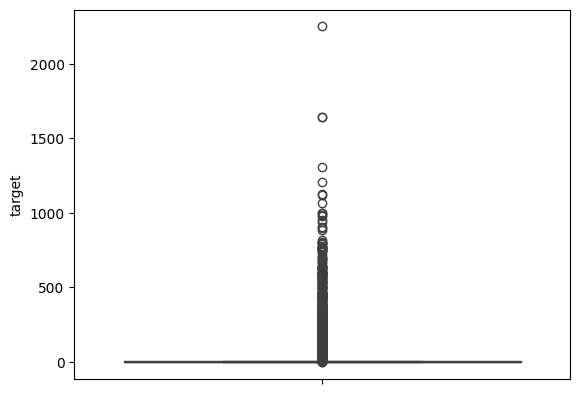

In [12]:
sns.boxplot(y='target', data=sales_agg_features_target_train_test)

In [32]:
sales_agg_features_target_train_test['target'].describe()

count    676738.000000
mean          2.976864
std          11.916152
min          -4.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2253.000000
Name: target, dtype: float64

Text(0.5, 1.0, 'Number of Dependents')

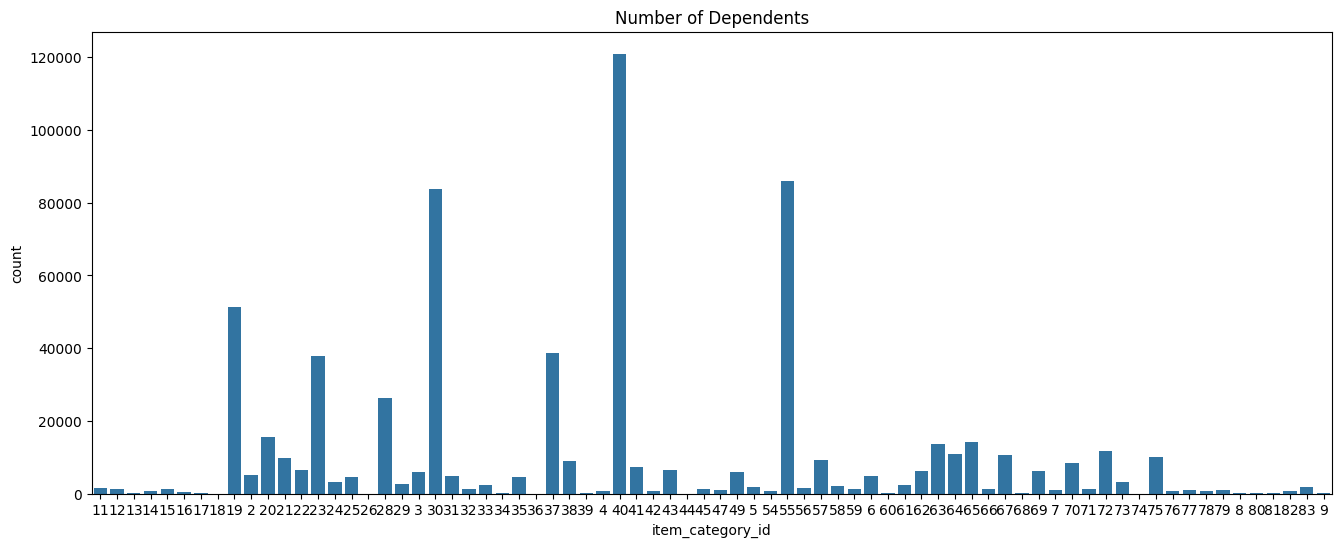

In [15]:
plt.figure(figsize=(16,6))
sns.countplot(x = 'item_category_id', data = sales_agg_features_target_train_test.sort_values(by='item_category_id')).set_title('Number of Dependents')

<Axes: xlabel='date_block_num'>

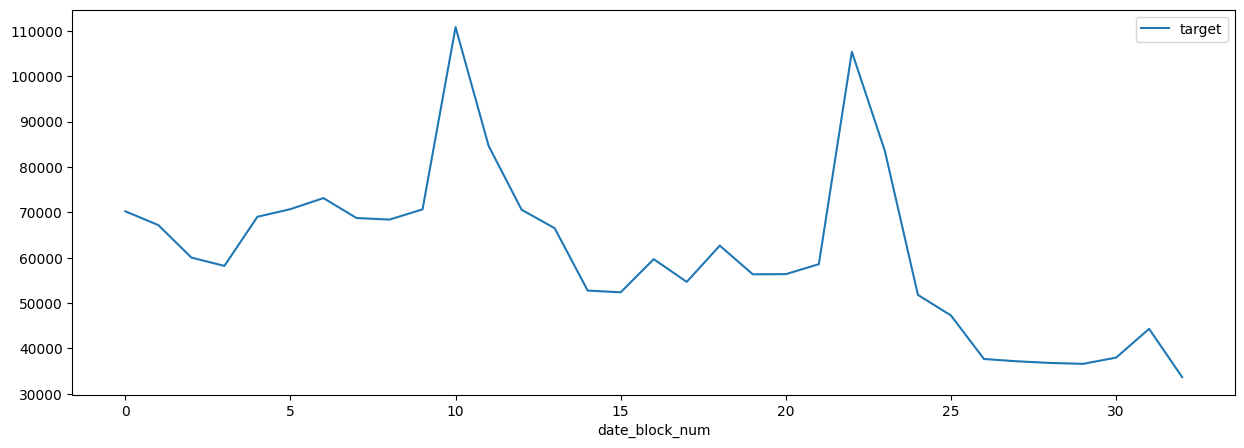

In [19]:
sales_agg_features_target_train_test['date_block_num'] = sales_agg_features_target_train_test['date_block_num'].astype(int)
sales_agg_features_target_train_test = sales_agg_features_target_train_test.sort_values(by='date_block_num',ascending=True)

dsa=sales_agg_features_target_train_test.groupby(["date_block_num"])['target'].sum().reset_index()
dsa = dsa.set_index('date_block_num')
dsa.plot(figsize=(15,5))

In [22]:
sales_agg_features_target_train_test.columns

Index(['ID', 'item_category_id', 'date_block_num', 'item_price_sum',
       'item_price_mean', 'item_cnt_day_sum', 'item_cnt_day_mean', 'target'],
      dtype='object')

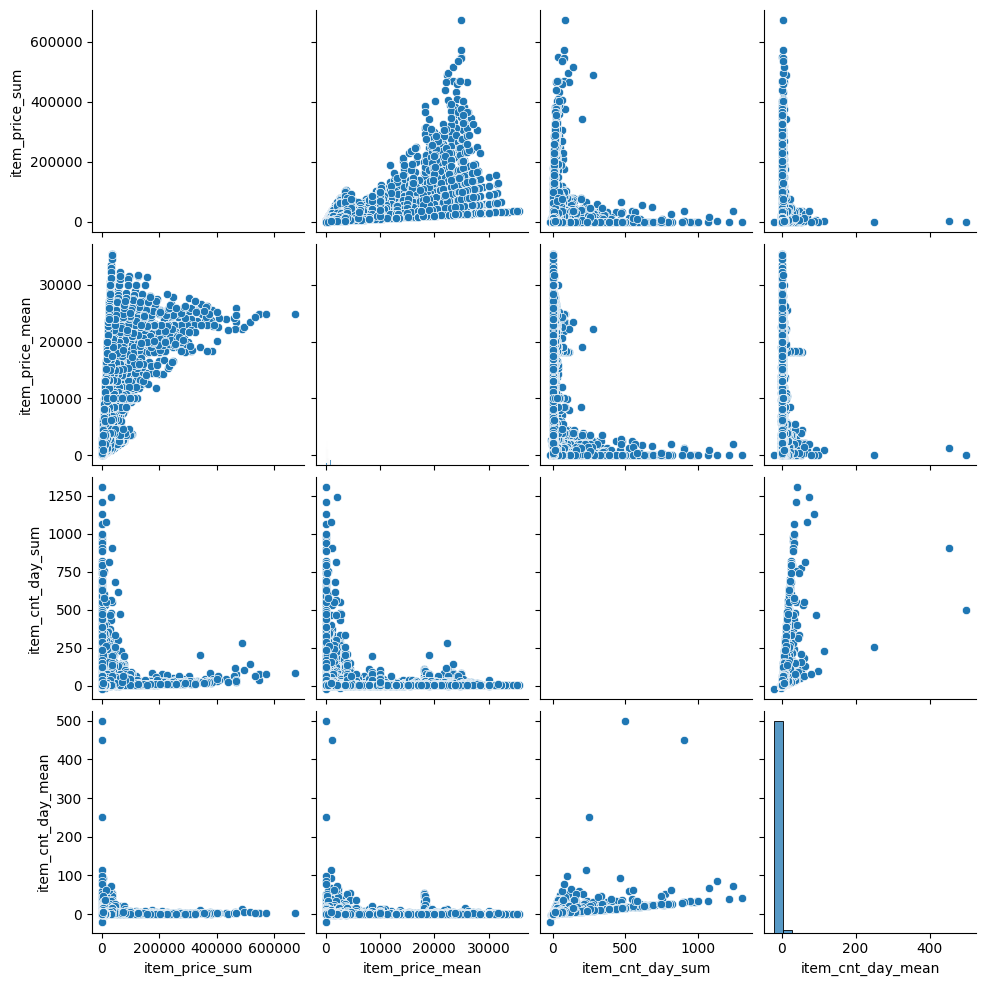

In [23]:
sns.pairplot(sales_agg_features_target_train_test[['item_price_sum', 'item_price_mean', 'item_cnt_day_sum', 'item_cnt_day_mean']])

<Axes: >

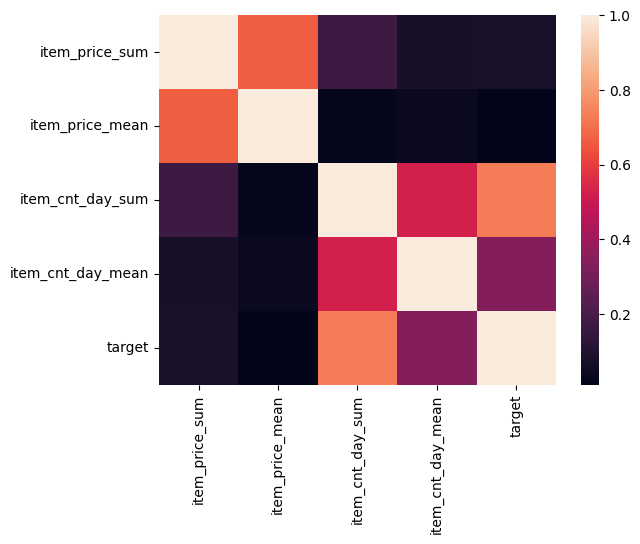

In [25]:
corr = sales_agg_features_target_train_test.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [35]:
sales_train = sales_agg_features_target_train_test[~sales_agg_features_target_train_test['date_block_num'].isin([25,26,27,28,29,30,31,32,33])]
sales_test = sales_agg_features_target_train_test[sales_agg_features_target_train_test['date_block_num'].isin([25,26,27,28,29,30,31,32,33])]
print(sales_test.shape[0]/sales_agg_features_target_train_test.shape[0], sales_train.shape[0]/sales_agg_features_target_train_test.shape[0])

0.16834284464593388 0.8316571553540661


In [36]:
sales_train['item_category_id'] = sales_train['item_category_id'].astype(str)
sales_test['item_category_id'] = sales_test['item_category_id'].astype(str)
sales_train['date_block_num'] = sales_train['date_block_num'].astype(str)
sales_test['date_block_num'] = sales_test['date_block_num'].astype(str)

In [37]:
sales_train.dtypes

ID                    object
item_category_id      object
date_block_num        object
item_price_sum       float64
item_price_mean      float64
item_cnt_day_sum     float64
item_cnt_day_mean    float64
target               float64
dtype: object

In [38]:
sales_train.to_csv('./data/train.csv',sep=',',index=False)
sales_test.to_csv('./data/test.csv',sep=',',index=False)

In [19]:
N_THREADS = 24
N_FOLDS = 4
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600
TARGET_NAME = 'target'

In [20]:
task = Task("reg", greater_is_better=False, metric="mse", loss="mse")

roles = {
    'target': TARGET_NAME,
    'drop': ['ID'],
    'numeric':['item_price_sum', 'item_price_mean', 'item_cnt_day_sum', 'item_cnt_day_mean'],
    'category':['item_category_id', 'date_block_num']
}

automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [21]:
%%time 
out_of_fold_predictions = automl.fit_predict(sales_train, roles = roles, verbose = 1)

[05:37:28] Stdout logging level is INFO.
[05:37:28] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[05:37:28] Task: reg

[05:37:28] Start automl preset with listed constraints:
[05:37:28] - time: 3600.00 seconds
[05:37:28] - CPU: 24 cores
[05:37:28] - memory: 16 GB

[05:37:28] Train data shape: (562814, 8)

[05:37:37] Layer 1 train process start. Time left 3590.86 secs
[05:37:41] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[05:38:04] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -43.634176877300526
[05:38:04] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[05:38:04] Time left 3563.77 secs

[05:38:08] Selector_LightGBM fitting and predicting completed
[05:38:11] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[05:38:23] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -34.21963875694941
[05:38:23] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[05:38:23] Start hyperparameters optimization for Lv

In [22]:
%%time

test_predictions = automl.predict(sales_test)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[ 1.2744274],
       [ 1.8708632],
       [14.375582 ],
       ...,
       [ 1.3824899],
       [ 1.3824899],
       [ 1.3455229]], dtype=float32)
Shape = (113924, 1)
CPU times: user 22.7 s, sys: 91.1 ms, total: 22.8 s
Wall time: 1.42 s


In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print(f'OOF score: {sqrt(mean_squared_error(sales_train[TARGET_NAME].values, out_of_fold_predictions.data[:, 0]))}')
print(f'HOLDOUT score: {sqrt(mean_squared_error(sales_test[TARGET_NAME].values, test_predictions.data[:, 0]))}')

OOF score: 5.757023926369013
HOLDOUT score: 11.651347913725791


In [24]:
import joblib

joblib.dump(automl,'automl_best.pkl')

['automl_best.pkl']

In [25]:
automl_best = joblib.load('./automl_best.pkl')
automl_best

In [26]:
test_predictions = automl_best.predict(sales_test)
print(f'OOF score: {sqrt(mean_squared_error(sales_train[TARGET_NAME].values, out_of_fold_predictions.data[:, 0]))}')
print(f'HOLDOUT score: {sqrt(mean_squared_error(sales_test[TARGET_NAME].values, test_predictions.data[:, 0]))}')

OOF score: 5.757023926369013
HOLDOUT score: 11.651347913725791


In [49]:
%%time

print(automl.create_model_str_desc())

RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

out_of_fold_predictions = automl_rd.fit_predict(sales_train, roles = roles, verbose = 1)

Final prediction for new objects (level 0) = 
	 0.94397 * (4 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.05603 * (4 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 
[19:16:27] Stdout logging level is INFO.
[19:16:27] Task: reg

[19:16:27] Start automl preset with listed constraints:
[19:16:27] - time: 3600.00 seconds
[19:16:27] - CPU: 10 cores
[19:16:27] - memory: 16 GB

[19:16:27] Train data shape: (562814, 8)



[19:16:30] Layer 1 train process start. Time left 3596.60 secs
[19:16:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:16:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -43.63457683725928
[19:16:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:16:47] Time left 3579.36 secs

[19:16:50] Selector_LightGBM fitting and predicting completed
[19:16:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:16:59] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -34.21963875694941
[19:16:59] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:16:59] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[19:21:11] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[19:21:11] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[19:21:27] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -33.06256633456075
[19:21:27] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and p

In [50]:
%%time

test_predictions = automl_rd.predict(sales_test)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[ 1.4611336],
       [ 1.9486432],
       [13.493805 ],
       ...,
       [ 1.4143926],
       [ 1.4143926],
       [ 1.4046563]], dtype=float32)
Shape = (113924, 1)
CPU times: user 1min 56s, sys: 6.31 s, total: 2min 2s
Wall time: 1min 44s


In [51]:
print(f'OOF score: {sqrt(mean_squared_error(sales_train[TARGET_NAME].values, out_of_fold_predictions.data[:, 0]))}')
print(f'HOLDOUT score: {sqrt(mean_squared_error(sales_test[TARGET_NAME].values, test_predictions.data[:, 0]))}')

OOF score: 5.745060576144152
HOLDOUT score: 11.680519949432064


## Feature importances calculation

CPU times: user 28.3 ms, sys: 19.2 ms, total: 47.5 ms
Wall time: 36 ms


<Axes: xlabel='Feature'>

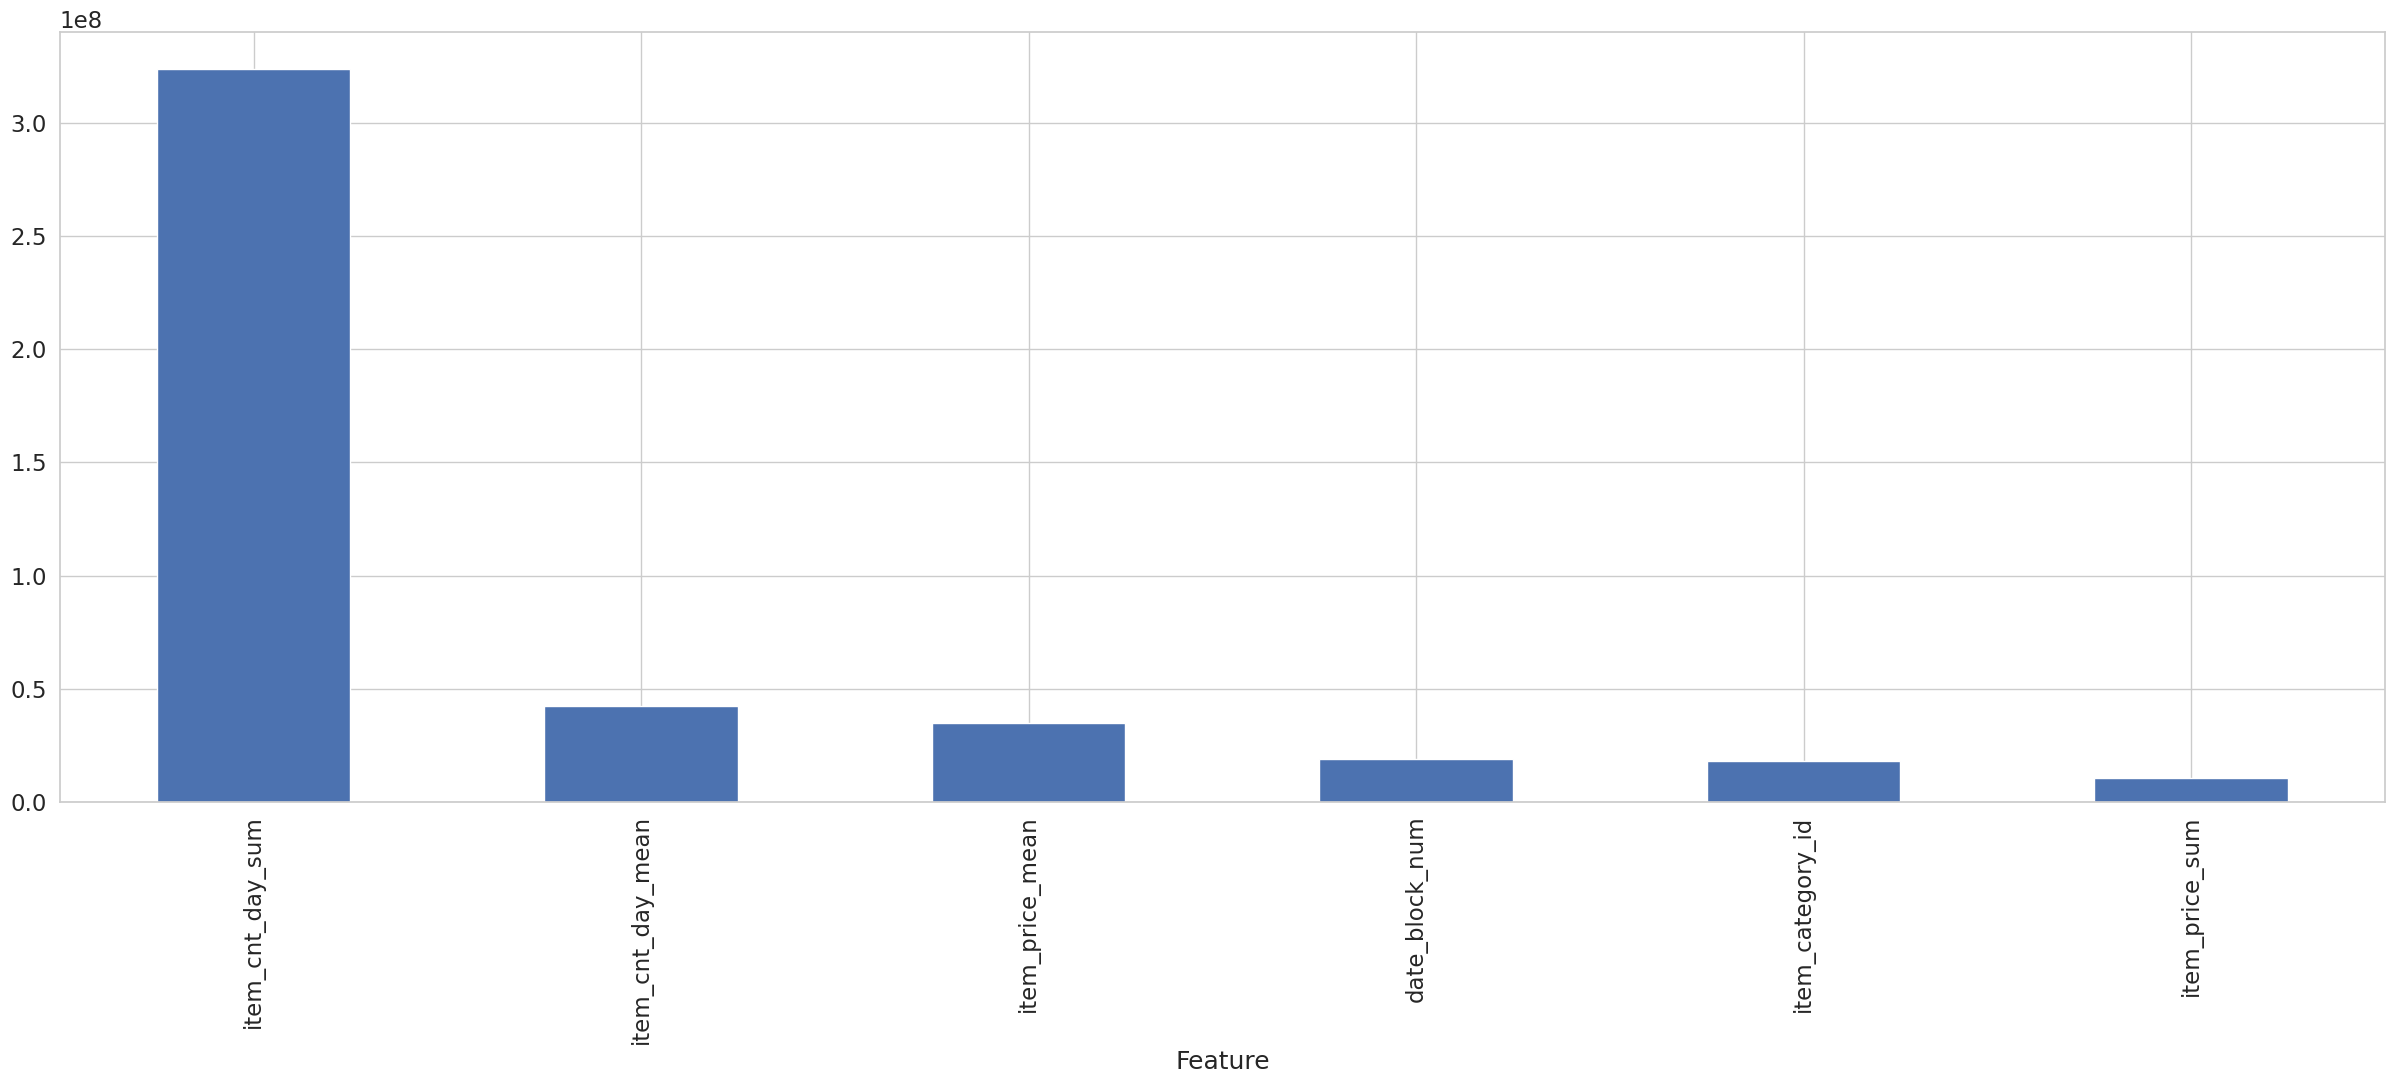

In [52]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)